In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
import experiments.utils.drawing

In [2]:
metaserieses = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
serieses = [1, 2, 21, 22, 41, 42, 61, 62, 81, 82]

series_meta = {
    "lstm": {"video": 1, "audio-qa": 21, "audio-sent": 41, "sum-qa": 61, "nlp": 81},
    "reactive": {"video": 2, "audio-qa": 22, "audio-sent": 42, "sum-qa": 62, "nlp": 82},
}


series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    config = configs_exp["0.yaml"]
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

In [4]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [5]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [6]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Total core changes

In [7]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

# -----------------------------
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

# -----------------------------

total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
xlabel = "Pipelines"
legend = "Predictor"

for exp, value in total_core_changes.items():
    value["total"] = (np.array(value["total"]) / len(value["total"])).tolist()
total_core_changes_total = {
    key: value["total"] for key, value in total_core_changes.items()
}

# Real Latencies

In [9]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [10]:
if not all(simulation_modes.values()):
    metric = "p99"  # [min, max, p99]
    metrics_all = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            metric_columns = list(
                filter(lambda col: metric in col, per_second_results[series].columns)
            )
            metrics_all[series] = per_second_results[series][metric_columns]
            # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
            metrics_all[series] = metrics_all[series].to_dict(orient="list")
            # draw_temporal(metrics_all[series])
    ylabel = "Second"
    # draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
    # draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

## timeouts

In [11]:
import numpy as np

legend = "Predictor"
ylabel = "% SLA Violations"
xlabel = "Pipelines"

timeout_dics = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        timeout_dics[series] = (
            np.array(timeout_per_second[series]) / sum(sent_loads[series]) * 100
        ).tolist()
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

69 out of 14437
368 out of 14437
93 out of 14437
683 out of 14437
50 out of 14437
139 out of 14437
803 out of 14437
1647 out of 14437
257 out of 14437
463 out of 14437


/home/cc/ipa/experiments/utils/drawing.py:556: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_names)


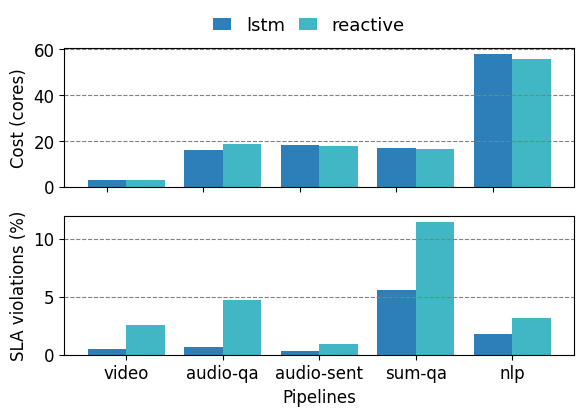

In [12]:
import importlib

importlib.reload(experiments.utils.drawing)

data = {"Cost (cores)": total_core_changes_total, "SLA violations (%)": timeout_dics}

bbox_to_anchor=(0.7, 2.55)

experiments.utils.drawing.draw_cumulative_with_grouping(
    data,
    series_meta=series_meta,
    xlabel=xlabel,
    filename=f"{FIGURES_PATH}/predictor-abelation-sla",
    colors=["#2c7fb8", "#41b6c4"],
    bbox_to_anchor=bbox_to_anchor,
    bar_width=0.4,
)